# Packages

In [1]:
import pandas as pd
import numpy as np
from numpy import where
import numpy.ma as ma


from netCDF4 import Dataset
import os
import netCDF4

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

import gsw

# UPLOADING VARIABLES 


In [2]:
file = 'WOA_ARGO_clim_V2019_NE.nc'
nc= Dataset(file)
print(nc)

year = nc['YEAR'][:]
var= nc['VAR_Z']

lat = nc['LAT'][:]
lon = nc['LON'][:]

idy=np.where(np.logical_and(year>= 2007, year<= 2017))
idy=np.where(np.logical_and(lat<=20, lon<= 65))
print(idy[0])

# profondeur
zanc=var[0,idy[0],:]
##z=zanc[np.logical_not(np.isnan(zanc))]
#Salinité
Sanc=var[2,idy[0],:]
#Temperature
Tanc=var[3,idy[0],:]
#Densité
Dens=var[4,idy[0],:]


lat = nc['LAT'][idy[0]]
lon = nc['LON'][idy[0]]

var2 = nc['CLIM_Z']

#Salinité
Sanc2=var2[2,idy[0],:]
#Temperature
Tanc2=var2[3,idy[0],:]
#Densité
Dens2=var2[4,idy[0],:]

#Density Anomaly
Dens_ano = Dens- Dens2

# Spiciness
sp = gsw.spiciness0(Sanc,Tanc)
sp_clim= gsw.spiciness0(Sanc2,Tanc2)

# Spiciness Anomaly
sp_ano = sp -sp_clim


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Var 0:Depth; 1:Presssure; 2:Salinity; 3:Temperature; 4:Density; 5:Chlorophyl; 6:Oxygen
    dimensions(sizes): N_profile(60406), N_profile_month(9828), N_variable(7), N_clim(5), N_clim_grid(3), Z_dimension(402), Sigma_dimension(1000), Month_dimension(12), Lon_dimension(117), Lat_dimension(105)
    variables(dimensions): float32 LON(N_profile), float32 LAT(N_profile), float32 YEAR(N_profile), float32 MONTH(N_profile), float32 DAY(N_profile), float64 NAME(N_profile), int64 MONTH_dim(Month_dimension), int64 VAR_dim(N_variable), int64 CLIM_dim(N_clim), int64 CLIM_GRID_dim(N_clim_grid), float32 DEPTH(Z_dimension), float32 SIGMA(Sigma_dimension), float32 LON_GRID(Lon_dimension), float32 LAT_GRID(Lat_dimension), float32 LON_MONTH(Month_dimension, N_profile_month), float32 LAT_MONTH(Month_dimension, N_profile_month), float32 VAR_Z(N_variable, N_profile, Z_dimension), float32 CLIM_Z(N_clim, N_p

In [3]:
print(np.nanmax(Dens_ano))
print(np.nanmin(Dens_ano))
print(np.nanmax(sp_ano))
print(np.nanmin(sp_ano))

5.1164074
-3.6686306
4.517677404285507
-5.343487077571595


# 1 PROFILE IDX 

In [4]:
idx = np.max(np.where(np.logical_and(lon <=61 , lat <= 23 )))
print(idx)
print(Sanc[idx,:])
print(zanc[idx,:])

13287
[      nan       nan 35.89237  35.876305 35.888584 35.895313 35.91
 35.838882 35.65703  35.58595  35.58039  35.56901  35.613655 35.644444
 35.639313 35.64229  35.610577 35.574566       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
    

In [5]:
# Inititaion des variables 

Spr= Sanc[idx,:]
Tpr= Tanc[idx,:]
dens_ano_pr= Dens_ano[idx,:]
spi_ano_pr = sp_ano[idx,:].data
z_pr = zanc[idx,:]

#remplacer les nans
#Spr[np.isnan(Spr)]= 9999
#Tpr[np.isnan(Tpr)]= 9999
#dens_ano_pr[np.isnan(dens_ano_pr)]= 9999
#spi_ano_pr[np.isnan(spi_ano_pr)]= 9999


 # DataFrame pour le profil IDX

In [6]:
data = pd.DataFrame(list(zip(z_pr,Tpr,Spr,Dens[idx,:],dens_ano_pr,spi_ano_pr)),
               columns =['Depth','Temperature','Salinity','Density','Density Anomaly','Spiciness Anomaly'])
X = pd.DataFrame(data)
# Observe the result
X

,Depth,Temperature,Salinity,Density,Density Anomaly,Spiciness Anomaly
0,0.0,NaN,NaN,NaN,NaN,NaN
1,-5.0,NaN,NaN,NaN,NaN,NaN
2,-10.0,26.649944,35.892368,23.503546,0.111938,-0.480490
3,-15.0,26.617769,35.876305,23.502052,0.056480,-0.454501
4,-20.0,26.586895,35.888584,23.521507,0.015493,-0.389119
...,...,...,...,...,...,...
397,-1985.0,NaN,NaN,NaN,NaN,NaN
398,-1990.0,NaN,NaN,NaN,NaN,NaN
399,-1995.0,NaN,NaN,NaN,NaN,NaN
400,-2000.0,NaN,NaN,NaN,NaN,NaN


In [7]:
## suppression des lignes contenant des Nans de LA DataFrame

index_with_nan = X.index[X.isnull().any(axis=1)]
X.drop(index_with_nan,0, inplace=True) 
X

C:\Users\beyas\AppData\Local\Temp\ipykernel_6148\3112839600.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X.drop(index_with_nan,0, inplace=True)


,Depth,Temperature,Salinity,Density,Density Anomaly,Spiciness Anomaly
2,-10.0,26.649944,35.892368,23.503546,0.111938,-0.480490
3,-15.0,26.617769,35.876305,23.502052,0.056480,-0.454501
4,-20.0,26.586895,35.888584,23.521507,0.015493,-0.389119
5,-25.0,26.563639,35.895313,23.534372,-0.063244,-0.260825
6,-30.0,26.556999,35.910000,23.547962,-0.172590,-0.084824
7,-35.0,24.929968,35.838882,23.998837,0.107483,-0.382463
8,-40.0,23.327440,35.657028,24.339861,0.289288,-0.763207
9,-45.0,22.522326,35.585949,24.520813,0.346197,-0.870979
10,-50.0,21.110250,35.580391,24.911869,0.613546,-1.096691
11,-55.0,20.592463,35.569012,25.044153,0.640343,-1.117581


# KMEANS pour IDX

In [8]:
km = KMeans(n_clusters= 2)
km

KMeans(n_clusters=2)

In [9]:
y_pred=km.fit_predict(X[['Spiciness Anomaly','Density Anomaly']])
y_pred

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
X['cluster']= y_pred
X.head()

,Depth,Temperature,Salinity,Density,Density Anomaly,Spiciness Anomaly,cluster
2,-10.0,26.649944,35.892368,23.503546,0.111938,-0.480490,0
3,-15.0,26.617769,35.876305,23.502052,0.056480,-0.454501,0
4,-20.0,26.586895,35.888584,23.521507,0.015493,-0.389119,0
5,-25.0,26.563639,35.895313,23.534372,-0.063244,-0.260825,0
6,-30.0,26.556999,35.910000,23.547962,-0.172590,-0.084824,0


In [11]:
km.cluster_centers_

array([[-0.34203714,  0.00926018],
       [-0.99422418,  0.6105051 ]])

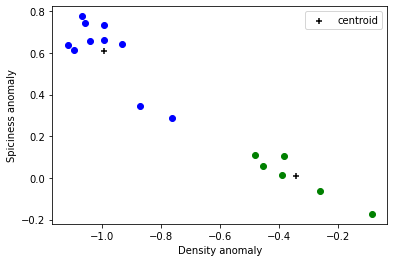

In [12]:
X1  = X[X.cluster==0]

X2  = X[X.cluster==1]
#X3  = X[X.cluster==2]


plt.scatter(X1['Spiciness Anomaly'],X1['Density Anomaly'], color= 'green')
plt.scatter(X2['Spiciness Anomaly'],X2['Density Anomaly'], color= 'blue')
#plt.scatter(X3['Spiciness Anomaly'],X3['Density Anomaly'], color= 'black')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color = 'black',marker='+', label='centroid')

plt.xlabel('Density anomaly')
plt.ylabel('Spiciness anomaly')
plt.legend()

C:\Users\beyas\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[3.470010550497438, 0.5193478112186822, 0.22663409368784804, 0.09221353964493934, 0.0704199962588991, 0.048953463737510944, 0.031249916018284425, 0.0238230799351081, 0.016631289321937946]


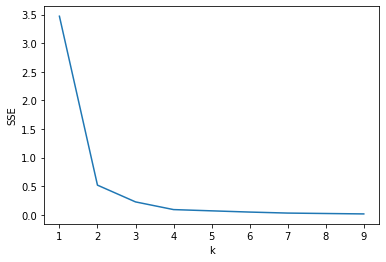

In [13]:
k_rng = range(1,10)
sse=[]
for k in k_rng:
    km= KMeans(n_clusters=k)
    km.fit(X[['Spiciness Anomaly','Density Anomaly']])
#if km.inertia_ <= 1 :
    sse.append(km.inertia_)
    #else :
    #pass 
print(sse)

plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(k_rng,sse)

##  TEMPERATURE - SALINTY

In [14]:
km = KMeans(n_clusters= 2)
km

KMeans(n_clusters=2)

In [15]:
y_pred=km.fit_predict(X[['Temperature','Salinity']])
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
X['clusterTS']= y_pred
X.head()

,Depth,Temperature,Salinity,Density,Density Anomaly,Spiciness Anomaly,cluster,clusterTS
2,-10.0,26.649944,35.892368,23.503546,0.111938,-0.480490,0,0
3,-15.0,26.617769,35.876305,23.502052,0.056480,-0.454501,0,0
4,-20.0,26.586895,35.888584,23.521507,0.015493,-0.389119,0,0
5,-25.0,26.563639,35.895313,23.534372,-0.063244,-0.260825,0,0
6,-30.0,26.556999,35.910000,23.547962,-0.172590,-0.084824,0,0


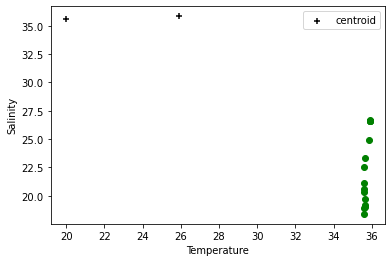

In [17]:
X1  = X[X.clusterTS==0]
X2  = X[X.clusterTS==1]


plt.scatter(X1['Salinity'],X1['Temperature'], color= 'green')
plt.scatter(X2['Salinity'],X2['Temperature'], color= 'green')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color = 'black',marker='+', label='centroid')

plt.xlabel('Temperature')
plt.ylabel('Salinity')
plt.legend()

## Density - Depth 

In [18]:
km = KMeans(n_clusters= 2)
km

KMeans(n_clusters=2)

In [19]:
y_pred=km.fit_predict(X[['Depth','Density']])
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
X['clusterDens']= y_pred
X.head()

,Depth,Temperature,Salinity,Density,Density Anomaly,Spiciness Anomaly,cluster,clusterTS,clusterDens
2,-10.0,26.649944,35.892368,23.503546,0.111938,-0.480490,0,0,0
3,-15.0,26.617769,35.876305,23.502052,0.056480,-0.454501,0,0,0
4,-20.0,26.586895,35.888584,23.521507,0.015493,-0.389119,0,0,0
5,-25.0,26.563639,35.895313,23.534372,-0.063244,-0.260825,0,0,0
6,-30.0,26.556999,35.910000,23.547962,-0.172590,-0.084824,0,0,0


In [21]:
km.cluster_centers_

array([[-27.5     ,  23.808619],
       [-67.5     ,  25.318043]], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


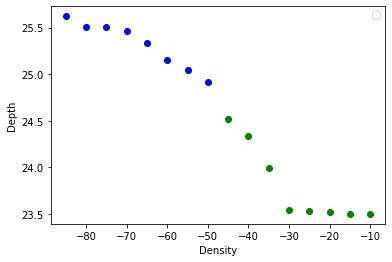

In [22]:
X1  = X[X.clusterDens==0]
X2  = X[X.clusterDens==1]


plt.scatter(X1['Depth'],X1['Density'], color= 'green')
plt.scatter(X2['Depth'],X2['Density'], color= 'blue')

plt.xlabel('Density')
plt.ylabel('Depth')
plt.legend()

## COUNTER CLASSIFICATION
# Create a DataFrame with labels and varieties as columns: df
df = pd.DataFrame({'Labels': labels, 'Clusters': pred})

# Create crosstab: ct
ct = pd.crosstab(df['Labels'], df['Clusters'])

# Display ct
print(ct)

# DataFrame pour les profiles IDY

In [23]:
idy=np.where(np.logical_and(year>= 2007, year<= 2017))
idy=np.where(np.logical_and(lat<=20, lon<= 65))
#print(idy[0])
#print(Sanc.shape)
print(len(Sanc[idy[0],0]))
print(Sanc[0])
print(len(Sanc[0,:]))
len(Sanc[0])

13475
[36.002    36.002    36.006878 36.000034 36.00095  36.001    36.001
 36.001083 36.002293 36.006    36.006    36.004868 36.003853 35.9988
 36.027317 36.09111  35.962055 35.837795 35.840843 35.778744 35.68102
 35.659702 35.553795 35.53496  35.524    35.516945 35.52136  35.534195
 35.61284  35.61089  35.65109  35.70121  35.708282 35.650005 35.602848
 35.49497  35.461296 35.41809  35.453247 35.485542 35.506367 35.532196
 35.53727  35.510033 35.46219  35.389225 35.341953 35.334087 35.406578
 35.470646 35.687923 36.131374 36.146824 36.168335 36.23674  36.222206
 36.207993 36.224285 36.293205 36.388622 36.39412  36.375137 36.397556
 36.39859  36.393    36.38759  36.357742 36.292274 36.144894 36.132885
 35.99197  35.985    35.94626  35.915886 35.878017 35.830856 35.8095
 35.756542 35.705162 35.6821   35.668    35.64926  35.67585  35.687588
 35.721    35.734344 35.74875  35.795048 35.798557 35.772877 35.75451
 35.74717  35.769    35.76339  35.764687 35.76256  35.74461  35.706898
 35.68304

402

Z= zanc[0]
i=1
for i in range(13475):
    Z= np.append(Z,zanc[i])
    i+= 1
    
    
S= Sanc[0]
i=1
for i in range(13475):
    S= np.append(S,Sanc[i])
    i+= 1

T= Tanc[0]
i=1
for i in range(13475):
    T= np.append(T,Tanc[i])
    i+= 1


D= Dens[0]
i=1
for i in range(13475):
    D= np.append(D,Dens[i])
    i+= 1

D_ano=Dens_ano[0]
i=1
for i in range(13475):
    S= np.append(S,Dens_ano[i])
    i+= 1
    
Sp_ano=sp_ano[0]
i=1
for i in range(13475):
    S= np.append(S,sp_ano[i])
    i+= 1
    

data = pd.DataFrame(list(zip(Z,T,S,D,D_ano,Sp_ano)),
               columns =['Depth','Temperature','Salinity','Density','Density Anomaly','Spiciness Anomaly'])
X = pd.DataFrame(data)
    

In [ ]:
data = pd.DataFrame(list(zip(zanc[0],Tanc[0],Sanc[0],Dens[0],Dens_ano[0],sp_ano[0])),
               columns =['Depth','Temperature','Salinity','Density','Density Anomaly','Spiciness Anomaly'])
X = pd.DataFrame(data)

i = 1
for i in range(1,13475):
    Xd =pd.DataFrame({'Depth':zanc[i],'Temperature':Tanc[i],'Salinity':Sanc[i],'Density':Dens[i],'Density Anomaly':Dens_ano[i],'Spiciness Anomaly':sp_ano[i]})
    X= np.append(X,Xd)
    i+=1


In [ ]:
Z= zanc[0]
i=1
for i in range(13475):
    Z= np.append(Z,zanc[i])
    i+= 1
    
    
S= Sanc[0]
i=1
for i in range(13475):
    S= np.append(S,Sanc[i])
    i+= 1

T= Tanc[0]
i=1
for i in range(13475):
    T= np.append(T,Tanc[i])
    i+= 1


D= Dens[0]
i=1
for i in range(13475):
    D= np.append(D,Dens[i])
    i+= 1

D_ano=Dens_ano[0]
i=1
for i in range(13475):
    S= np.append(S,Dens_ano[i])
    i+= 1
    
Sp_ano=sp_ano[0]
i=1
for i in range(13475):
    S= np.append(S,sp_ano[i])
    i+= 1
    

data = pd.DataFrame(list(zip(Z,T,S,D,D_ano,Sp_ano)),
               columns =['Depth','Temperature','Salinity','Density','Density Anomaly','Spiciness Anomaly'])
X = pd.DataFrame(data)

# Creation de DATAFRAME de IDY

In [ ]:
## suppression des lignes contenant des Nans de LA DataFrame

index_with_nan = X.index[X.isnull().any(axis=1)]
X.drop(index_with_nan,0, inplace=True) 
print(X)

In [ ]:
ls
